In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Utilities
import re
import os
# Preprocessing
from html import unescape
from fuzzywuzzy import fuzz
# Data management
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

In [152]:
df = pd.read_csv("./data/book.txt", 
                   sep='\t', 
                   lineterminator='\n', 
                   header=None, 
                   names=["source", "isbn", "title", "authors"])

In [4]:
df.head()

,source,isbn,title,authors
0,eCampus.com,0201853949,"The art Of Computer Programming, Fascicle 3: G...",Not Available\r
1,Indoo.com,0201853949,"Art of Computer Programming, Volume 4, Fascicl...","Knuth, Donald E.\r"
2,textbookxdotcom,0201853949,"The 'art Of Computer Programming, Fascicle 3 G...",\r
3,A1Books,0201853949,"The Art of Computer Programming, Volume 4, Fas...","Knuth, Donald E.\r"
4,textbooksNow,0201853949,Art of Computer Programming,Knuth\r


In [154]:
df.describe()

,source,isbn,title,authors
count,33971,33971,33968,33971
unique,895,1265,11095,9627
top,A1Books,0321263588,Modern Database Management,\r
freq,2403,159,90,713


# Preprocessing

In [6]:
def clean(df, gs=False):
    if gs:
        df["authors"] = df["authors"].str.lower()
        df["authors"] = df["authors"].str.replace('[^\w\s]|\\r','')
        df.authors = df.authors.replace('\s+', ' ', regex=True)
        #df.authors = df.authors.replace(r'\b\w\b', ' ', regex=True)
 
        df['authors'] = df['authors'].str.strip()
    else:
        # Unescape HTML left over from scraping
        df.authors = df.authors.apply(unescape)
        df.title = df.title.apply(lambda x: unescape(str(x)))
        # Lowercase 
        df["authors"] = df["authors"].str.lower()
        df["title"] = df["title"].str.lower()
        df["source"] = df["source"].str.lower()
        # Removes parenthesis from author list
        df["authors"] = df["authors"].str.replace('\((.*?)\)','')
        # Replaces | in author list with spaces
        df["authors"] = df["authors"].str.replace('\|',' ')
        # Special characters removal (removes all special characters left)
        df["title"] = df["title"].str.replace('[^\w\s]|\\r','')
        df["authors"] = df["authors"].str.replace('[^\w\s]|\\r','')
        # Remove numbers from authors
        df['authors'] = df['authors'].str.replace('\d+', '')
        # Uniformize missing values
        df["authors"] = df["authors"].str.replace('not available','')
        df["authors"] = df["authors"].replace(r'^\s*$', np.nan, regex=True)
        # Remove doubled whitespaces
        df.authors = df.authors.replace('\s+', ' ', regex=True)
        df.title = df.title.replace('\s+', ' ', regex=True)
        # Remove trailing spaces
        df.authors = df.authors.str.strip()
        # Remove single characters in authors names
        #df.authors = df.authors.replace(r'\b\w\b', ' ', regex=True)

In [155]:
clean(df)

In [157]:
print(df.describe().to_latex())

\begin{tabular}{lllll}
\toprule
{} &   source &        isbn &                                 title &       authors \\
\midrule
count  &    33971 &       33971 &                                 33971 &         33172 \\
unique &      894 &        1265 &                                  7195 &          6901 \\
top    &  a1books &  0321263588 &  computer networking and the internet &  meyers scott \\
freq   &     2403 &         159 &                                   108 &           136 \\
\bottomrule
\end{tabular}



In [9]:
sum(df.duplicated())

7557

In [10]:
df = df.drop_duplicates()

# Data Quality Metrics

In [11]:
# Unique sources
sources = df.source.unique()

gs = pd.read_csv("./data/book_golden.txt", 
                   sep='\t', 
                   lineterminator='\n', 
                   header=None, 
                   names=["isbn", "authors"])
clean(gs, gs=True)
gs

,isbn,authors
0,9780073516677,oleary timothy j oleary linda i
1,9780072999389,yacht carol crosson susan
2,9780072922363,hutton david v
3,9780072843996,haag stephen perry james t sosinsky barrie est...
4,9780072466850,reddy j n
...,...,...
95,0122290631,eberly david h
96,0120887975,celko joe
97,0120455994,aiken peter allen m david
98,1555581994,cheek matthew


### Completeness
Attribute/Table completeness

NOTE: Closed World assumption

In [12]:
# Null values
null_count = df.isnull().sum()
null_count

source       0
isbn         0
title        0
authors    649
dtype: int64

In [13]:
# Attribute completeness
rows = df.shape[0]
attributes = list(df)
attribute_compl = {}

for attribute in attributes:
    attribute_compl[attribute] = 1 - (null_count[attribute] / rows)

attribute_compl = pd.DataFrame([attribute_compl])
attribute_compl

,source,isbn,title,authors
0,1.0,1.0,1.0,0.97543


In [14]:
# Table completeness
table_compl = 1 - (null_count.sum() / (len(attributes)*rows))
print(table_compl)

0.9938574240932838


### Accuracy (TO SKIP)
Accuracy is computed on the TruthFinder elements
For each source, matching of ISBN and authors list to Golden Standard

In [15]:
def compute_accuracy(source, gs):
    # Computes source accuracy by matching the golden standard rows to the source df, 
    # computing ISBN and Authors accuracy
        
    isbn_match_count = 0
    authors_match_count = 0
    authors_match_percentage = 0
    
    for gs_isbn, gs_authors in zip(gs.isbn, gs.authors):
        select = source[source.isbn == gs_isbn]
        select = select.dropna()
        if not select.empty:
            isbn_match_count += 1
            for authors in select.authors:
                tokens = authors.split()
                gs_tokens = gs_authors.split()
                match = fuzz.token_sort_ratio(tokens, gs_tokens)
                authors_match_percentage += match
                authors_match_count += 1
                
    acc = {
        "isbn": isbn_match_count/len(source.isbn),
        "authors": authors_match_percentage/authors_match_count
    }
    
    return acc

In [16]:
%%script False

source_accuracy = []

if not os.path.exists("./data/results/source_accuracy.csv"):
    for source in sources:
        selected_source = df[df.source == source]
        acc = compute_accuracy(df, gs)
        acc["source"] = source
        source_accuracy.append(acc)
    
    with open('./data/results/source_accuracy.csv', 'w') as f:
        f.write("{}; {}; {}".format("source", 
                                    "isbn coverage", 
                                    "authors accuracy"))
        for e in source_accuracy:
            f.write("{}; {}; {}".format(e["source"], 
                                        e["isbn"], 
                                        e["authors"]))
else:
    source_accuracy = pd.read_csv("./data/results/source_accuracy.csv", 
                   header=["source", "isbn coverage", "authors accuracy"])


Couldn't find program: 'False'


### Coverage
How much data of the dataset each source covers

In [17]:
source_coverage = {}
unique_isbn = len(df.isbn.unique())

if not os.path.exists("./data/results/source_coverage.csv"):
    
    for source in sources:
        selected_source = df[df.source == source]
        source_coverage[source] = len(selected_source.isbn.unique()) / unique_isbn
    with open('./data/results/source_coverage.csv', 'w') as f:
            f.write("{};{}\n".format("source","coverage"))
            for key, value in source_coverage.items():
                f.write("{}; {}\n".format(key, value))
                
else:
    source_coverage = pd.read_csv("data/results/source_coverage.csv", sep=";")

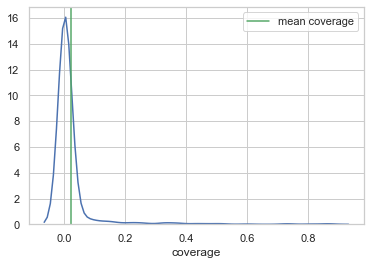

In [18]:
source_coverage = pd.DataFrame(source_coverage)

ax = sns.distplot(source_coverage.coverage, hist=False);
ax.axvline(source_coverage.coverage.mean(), color='g')
plt.legend({'mean coverage': source_coverage.coverage.mean()})

In [19]:
source_coverage.coverage.mean()

0.021946043451733555

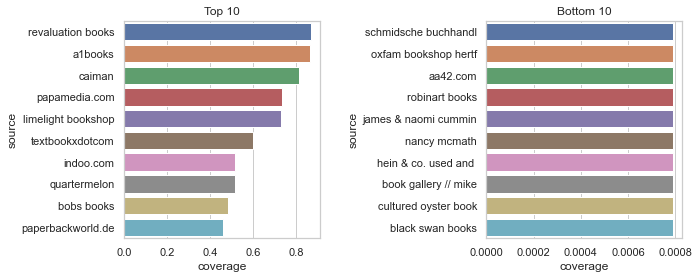

In [20]:
top_cover = source_coverage.nlargest(10, "coverage")
worst_cover = source_coverage.nsmallest(10, "coverage")

worst_cover.source = worst_cover.source.apply(lambda x:  x[:20])

fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
ax = sns.barplot(data=top_cover, x="coverage", y="source")

plt.title('Top 10')

plt.subplot(1, 2, 2)
ax = sns.barplot(data=worst_cover, x="coverage", y="source")
plt.title('Bottom 10')

fig.subplots_adjust(wspace=0.85)
plt.show()

In [21]:
# Final cleaning step, drop NaN rows
df = df.dropna()

# Data Fusion

## TruthFinder implementation

In [22]:
%%script False
# TODO: Add cosine similarity with TFIDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
tfidf = TfidfVectorizer(min_df=1).fit_transform(df["authors"])

# Finds similarity of first vector compared to every other, see 
# https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
cosine_similarities = linear_kernel(tfidf[0:1], tfidf).flatten()
related_docs_indices = cosine_similarities.argsort()[:-5:-1]
related_docs_indices

Couldn't find program: 'False'


In [23]:
from truthfinder import TruthFinder

In [24]:
finder = TruthFinder(df.copy(), 
                     fact="authors", 
                     obj="isbn")

result = finder.compute()

In [25]:
# Saving results
result.to_csv("./data/results/truth.csv", index=False)
finder.df.to_csv("./data/results/complete.csv", index=False)

In [27]:
sl = finder.df[finder.df["isbn"] == "0131420445"].sort_values("confidence")
sl

,source,isbn,title,authors,trust,confidence
33308,textbooksnow,0131420445,mips assembly language programming,britton,0.750440,0.717572
33317,sandy chong,0131420445,mips assembly language programming,britton robert l,0.915032,0.864479
33320,englishbookservice.com gti gmbh,0131420445,mips assembly language programming,britton robert l,0.968321,0.864479
33313,textbookxdotcom,0131420445,mips assembly language programming,robert britton,0.829355,0.874795
33315,odeon books,0131420445,mips assembly language programming,robert britton,0.967136,0.874795
33316,papamedia.com,0131420445,mips assembly language programming,robert britton,0.873361,0.874795
33310,indoo.com,0131420445,mips assembly language programming,britton robert,0.899343,0.920206
33311,a1books,0131420445,mips assembly language programming,britton robert,0.910781,0.920206
33312,caiman,0131420445,mips assembly language program,britton robert,0.899617,0.920206
33314,books2anywhere.com,0131420445,mips assembly language programming,britton robert,0.958828,0.920206


In [28]:
sl = finder.df[finder.df["isbn"] == "9780073516677"].sort_values("confidence")
sl[-5:-1]

,source,isbn,title,authors,trust,confidence
17931,textbookxdotcom,9780073516677,computing essentials,oleary timothy j oleary linda i,0.829355,0.965856
17938,revaluation books,9780073516677,computing essentials 2007 complete edition,oleary timothy j oleary linda i,0.923746,0.965856
17922,collegebooksdirect.com,9780073516677,computing essentials,oleary timothy j oleary linda i,0.935860,0.965856
17932,caiman,9780073516677,computing essentials 2007,oleary timothy j oleary linda i,0.899617,0.965856


## TruthFinder Accuracy with respect to the Gold Standard

In [29]:
# Create DF holding the GS authors and TF authors for matching
matching = gs.copy()
matching = matching.rename(columns = {'authors':'authors_gs'})
matching = pd.merge(matching, result, on=['isbn']) # Join
matching = matching.rename(columns = {'authors':'authors_tf'})
matching = matching[["isbn", "authors_gs", "authors_tf"]] # Select

In [30]:
from strsimpy.cosine import Cosine

def similarity(s1, s2):
    cosine = Cosine(2)
    p0 = cosine.get_profile(s1)
    p1 = cosine.get_profile(s2)
    return cosine.similarity_profiles(p0, p1)

tf_accuracy = 0.0

matching['accuracy'] = matching.apply(lambda row: 
                                      similarity(row["authors_gs"], 
                                                 row["authors_tf"]), 
                                      axis = 1)        
tf_accuracy = matching.accuracy.mean()

0.9227554992056092


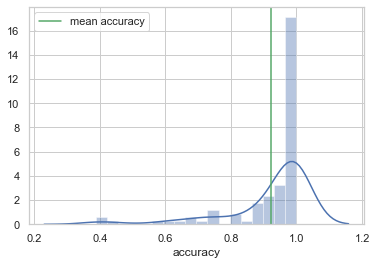

In [31]:
ax = sns.distplot(matching.accuracy);
ax.axvline(tf_accuracy, color='g')
plt.legend({'mean accuracy': tf_accuracy})
print(tf_accuracy)

0.9275428577739951


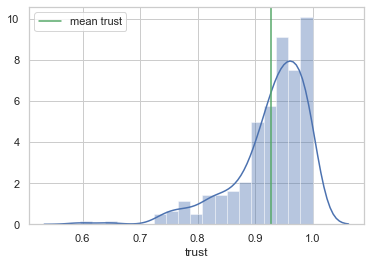

In [32]:
mean_trust = result.drop_duplicates("source").trust.mean()

ax = sns.distplot(result.drop_duplicates("source").trust);
ax.axvline(mean_trust, color='g')
plt.legend({'mean trust': mean_trust})
print(mean_trust)

### Top/Worst 5 matching instances

In [33]:
top5 = matching.nlargest(5,'accuracy')
worst5 = matching.nsmallest(5,'accuracy')

display(top5)
display(worst5)

,isbn,authors_gs,authors_tf,accuracy
2,9780072922363,hutton david v,hutton david v,1.0
32,1558601368,przybylski steven a,przybylski steven a,1.0
40,0750694998,pease robert a,pease robert a,1.0
41,0750677953,jones andy ashenden debi,jones andy ashenden debi,1.0
44,0750656832,pooley rob wilcox pauline,pooley rob wilcox pauline,1.0


,isbn,authors_gs,authors_tf,accuracy
6,9780072232172,suhanovs dennis,dennis suhanovs press certification certificat...,0.389381
99,1555582745,moore martin hancock steven,moore,0.392232
46,044450673X,jenssen c b kvamdal t andersson h i ecer a per...,jenssen c b,0.451447
13,1558609199,halpin terry evans ken hallock pat maclean bill,halpin terry,0.583874
59,0321219767,filman robert e elrad tzilla clarke siobhan ak...,filman robert e,0.617213


### Top/Worst 10 Sources

In [96]:
top_sources = result.drop_duplicates("source").nlargest(5, "trust")[["source", "trust"]]
worst_sources = result.drop_duplicates("source").nsmallest(5, "trust")[["source", "trust"]]

display(top_sources)
display(worst_sources)

,source,trust
488,spine and crown,1.0
476,er books,1.0
259,a novel idea bookstore,1.0
263,"strand book store, abaa",1.0
49,"gail p. kennon, book-comber",1.0


,source,trust
699,"reliable enterprises, inc.",0.523554
894,hyannisport books,0.646502
167,opoe-abe books,0.678901
703,textbooksnow,0.683280
20,technischer overseas pvt. ltd.,0.712872


### TruthFinder hyperparameters search

In [38]:
# Max iteration accuracy

max_iter = [1, 10, 20, 30]

search_results_it = []

for it in max_iter:
    finder = TruthFinder(df.copy(deep=True), 
                     fact="authors", 
                     obj="isbn",
                     initial_trust=0.8)
    
    result = finder.compute(max_it=it, tolerance=0.01, progress=True)
    
    matching = gs.copy(deep=True)
    matching = matching.rename(columns = {'authors':'authors_gs'})
    matching = pd.merge(matching, result, on=['isbn']) # Join
    matching = matching.rename(columns = {'authors':'authors_tf'})
    matching = matching[["isbn", "authors_gs", "authors_tf"]] # Select
    
    matching['accuracy'] = matching.apply(lambda row: 
                                      similarity(row["authors_gs"], 
                                                 row["authors_tf"]), 
                                      axis = 1)        
    accuracy = matching.accuracy.mean()
    search_results_it.append({"it": it, "accuracy": matching.accuracy.copy()})
    print("### Model params: max_it={}, Accuracy: {}".format(it, accuracy))

Iteration: 0, Error: 0.007509068747877046
### Model params: max_it=1, Accuracy: 0.9227554992056092
Iteration: 0, Error: 0.007509068747877046
Iteration: 1, Error: 0.00029568881379216094
Iteration: 2, Error: 9.308367088023406e-05
Iteration: 3, Error: 3.123884741806915e-05
Iteration: 4, Error: 9.88124925671574e-06
Iteration: 5, Error: 3.096563697679855e-06
Iteration: 6, Error: 9.739034650957379e-07
Iteration: 7, Error: 3.0482668655906764e-07
Iteration: 8, Error: 9.4001415873457e-08
Iteration: 9, Error: 2.8475935054395052e-08
### Model params: max_it=10, Accuracy: 0.9250619707842509
Iteration: 0, Error: 0.007509068747877046
Iteration: 1, Error: 0.00029568881379216094
Iteration: 2, Error: 9.308367088023406e-05
Iteration: 3, Error: 3.123884741806915e-05
Iteration: 4, Error: 9.88124925671574e-06
Iteration: 5, Error: 3.096563697679855e-06
Iteration: 6, Error: 9.739034650957379e-07
Iteration: 7, Error: 3.0482668655906764e-07
Iteration: 8, Error: 9.4001415873457e-08
Iteration: 9, Error: 2.847593

[Text(0, 0.5, 'error'), Text(0.5, 0, 'iterations')]

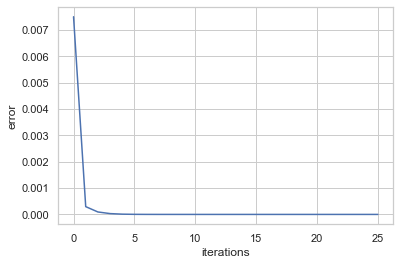

In [62]:
# Copied from the cell above because I forgot to store them and it takes too long to rerun it
errors = pd.Series([0.007509068747877046,
0.00029568881379216094,
9.308367088023406e-05,
3.123884741806915e-05,
9.88124925671574e-06,
3.096563697679855e-06,
9.739034650957379e-07,
3.0482668655906764e-07,
9.4001415873457e-08,
2.8475935054395052e-08,
8.500221082563542e-09,
2.5146995596969646e-09,
7.419382885842651e-10,
2.1964607910263112e-10,
6.563316556906784e-11,
1.9911072790534945e-11,
6.1670668571878196e-12,
1.959654660765864e-12,
6.412648190234904e-13,
2.170486013142181e-13,
7.549516567451064e-14,
2.653433028854124e-14,
1.0103029524088925e-14,
3.774758283725532e-15,
1.3322676295501878e-15,
4.440892098500626e-16])

ax = sns.lineplot(data=errors)
ax.set(xlabel='iterations', ylabel='error')
ax.set_yscale("log")

(0.922, 0.926)

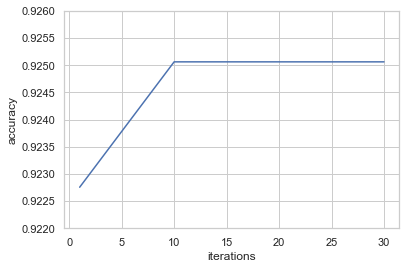

In [144]:
# Same as above
acc_it = {1:0.9227554992056092, 
          10:0.9250619707842509, 
          20:0.9250619707842509, 
          30:0.9250619707842509}
acc_it = pd.Series(acc_it)
ax = sns.lineplot(data=acc_it)
ax.set(xlabel='iterations', ylabel='accuracy')
ax.set_ylim([0.922,0.926])

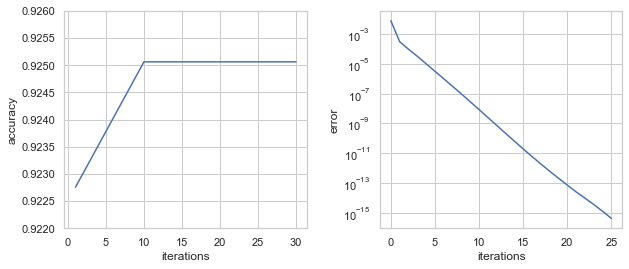

In [151]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=acc_it)
ax.set(xlabel='iterations', ylabel='accuracy')
ax.set_ylim([0.922,0.926])

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=errors)
ax.set(xlabel='iterations', ylabel='error')
ax.set_yscale("log")
fig.subplots_adjust(wspace=0.3)
plt.show()

In [84]:
ax = plt.figure()

for res in search_results_it: 
    sns.distplot(res["accuracy"], hist=False, 
                 label = "iteration = {}, acc = {:0.3f}".format(res["it"], res["accuracy"].mean()))
    

KeyError: 'it'

<Figure size 432x288 with 0 Axes>

In [40]:
# Damping and Relatedness grid search

import itertools

dampening = [0.1, 0.3, 0.5]
relatedness = [0.3, 0.5, 0.7]

search_results = []

for param in itertools.product(*[dampening, relatedness]):
    finder = TruthFinder(df.copy(), 
                     fact="authors", 
                     obj="isbn",
                     dampening_factor = param[0],
                     relatedness_factor = param[1],
                     initial_trust=0.8)

    result = finder.compute(tolerance=0.01)
    
    matching = gs.copy()
    matching = matching.rename(columns = {'authors':'authors_gs'})
    matching = pd.merge(matching, result, on=['isbn']) # Join
    matching = matching.rename(columns = {'authors':'authors_tf'})
    matching = matching[["isbn", "authors_gs", "authors_tf"]] # Select
    
    matching['accuracy'] = matching.apply(lambda row: 
                                      similarity(row["authors_gs"], 
                                                 row["authors_tf"]), 
                                      axis = 1)        
    accuracy = matching.accuracy.mean()
    search_results.append({"params": param, "accuracy": matching.accuracy.copy()})
    print("Params: {}, Accuracy: {}".format(param, accuracy))

Params: (0.1, 0.3), Accuracy: 0.8958010380756994
Params: (0.1, 0.5), Accuracy: 0.9281391810040098
Params: (0.1, 0.7), Accuracy: 0.9452262841386917
Params: (0.3, 0.3), Accuracy: 0.8921846518516073
Params: (0.3, 0.5), Accuracy: 0.9250619707842509
Params: (0.3, 0.7), Accuracy: 0.938234162995715
Params: (0.5, 0.3), Accuracy: 0.916163188278557
Params: (0.5, 0.5), Accuracy: 0.9291448053391587
Params: (0.5, 0.7), Accuracy: 0.9417096061501123


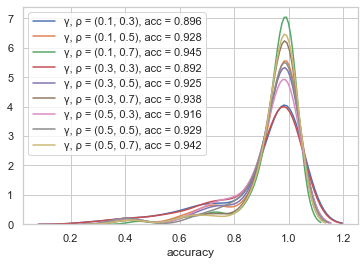

In [85]:
ax = plt.figure()

for res in search_results:
    sns.distplot(res["accuracy"], hist=False, 
                 label = "γ, ρ = {}, acc = {:0.3f}".format(res["params"], res["accuracy"].mean()))
    

In [75]:
heat.params[0][0]

0.1

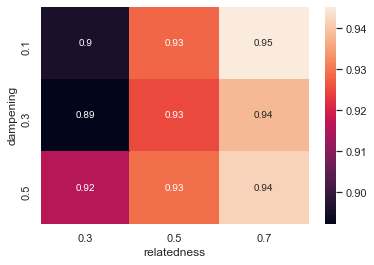

In [83]:
heat = pd.DataFrame(search_results)
heat.accuracy = heat.accuracy.apply(lambda x: x.mean())
heat["dampening"] = [x[0] for x in heat.params]
heat["relatedness"] = [x[1] for x in heat.params]
heat = heat.drop(['params'], axis=1)
heat = pd.pivot_table(heat, values='accuracy', 
                     index='dampening', 
                     columns='relatedness')

sns.heatmap(heat, annot=True)
